# Importing Necessary Libraries

In [1]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4464 sha256=55dea481721ce325e294f6b6c29fc2ae6ccd08309ffd06ed7e6513e91d7a5553
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=cd84431ba98df5fb8726e0d43adac74bf7075c7eb55579e34bc9e74957b6fb99
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer


In [2]:
import numpy as np
import pandas as pd
import silence_tensorflow.auto
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading the Brain Tumor MRI dataset

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

batch_size = 32
img_height = 300
img_width = 300

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=13,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=3,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
train_dataset = train_dataset.cache().shuffle(1024).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


# Printing some of the images from the training dataset

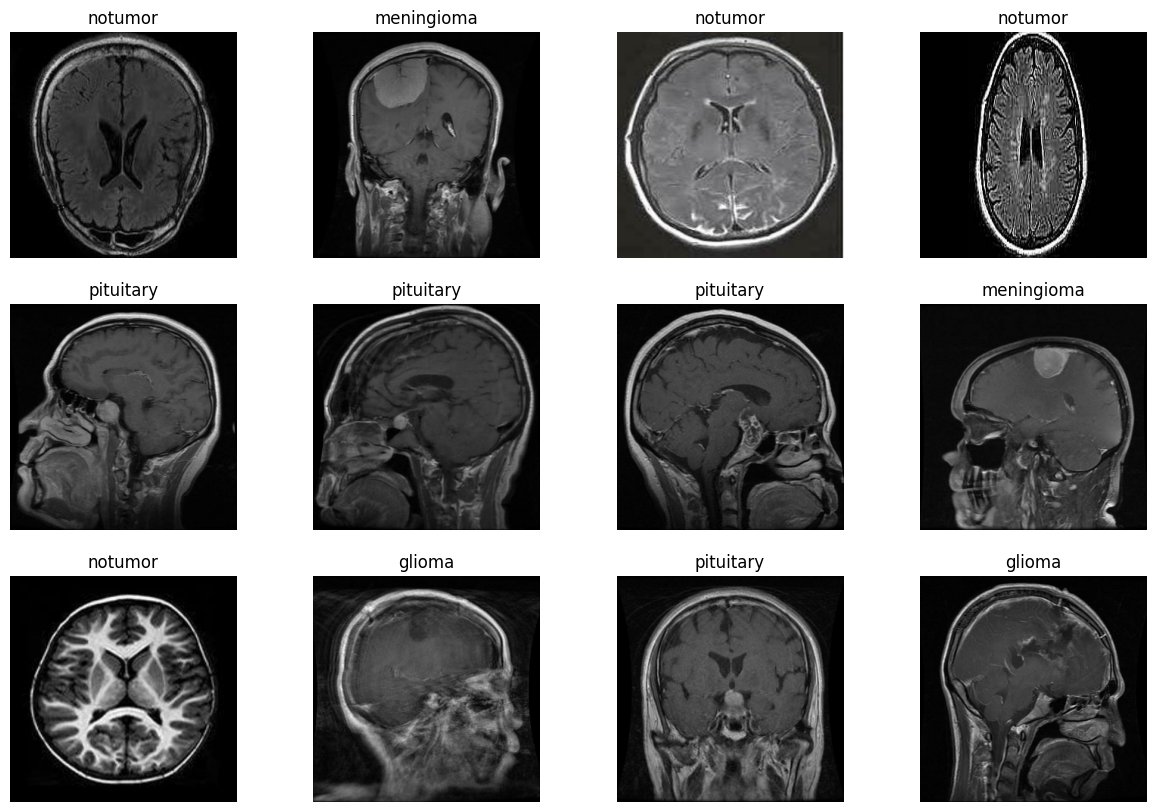

In [4]:
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Loading EfficientNetV2B1 Model for Fine-Tuning

In [5]:
base_model = tf.keras.applications.EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

for layer in base_model.layers[:251]:
   layer.trainable = False
for layer in base_model.layers[251:]:
   layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 7,589,048 (28.95 MB)

 Trainable params: 3,975,412 (15.16 MB)

 Non-trainable params: 3,613,636 (13.78 MB)

In [6]:
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoints/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Training Model

In [7]:
history = model.fit(train_dataset, epochs=100, callbacks=[checkpoint_callback, early_stopping, reduce_lr], validation_data = validation_dataset)

Epoch 1/100
  2/143 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.2734 - loss: 8.8142   

I0000 00:00:1719246154.151626     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4190 - loss: 8.6179
Epoch 1: val_loss improved from inf to 8.10264, saving model to model_checkpoints/epoch_01.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 169s 623ms/step - accuracy: 0.4197 - loss: 8.6168 - val_accuracy: 0.7557 - val_loss: 8.1026 - learning_rate: 1.0000e-05
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7362 - loss: 8.0307
Epoch 2: val_loss improved from 8.10264 to 7.57970, saving model to model_checkpoints/epoch_02.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.7363 - loss: 8.0299 - val_accuracy: 0.8301 - val_loss: 7.5797 - learning_rate: 1.0000e-05
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8169 - loss: 7.5550
Epoch 3: val_loss improved from 7.57970 to 7.15512, saving model to model_checkpoints/epoch_03.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.8170 - loss: 7.5543 - val_accuracy: 0.8643 - val_loss: 7.1551 - learning_rate: 1.0000e-05
Epoch

# Printing various metrics and results derived after training

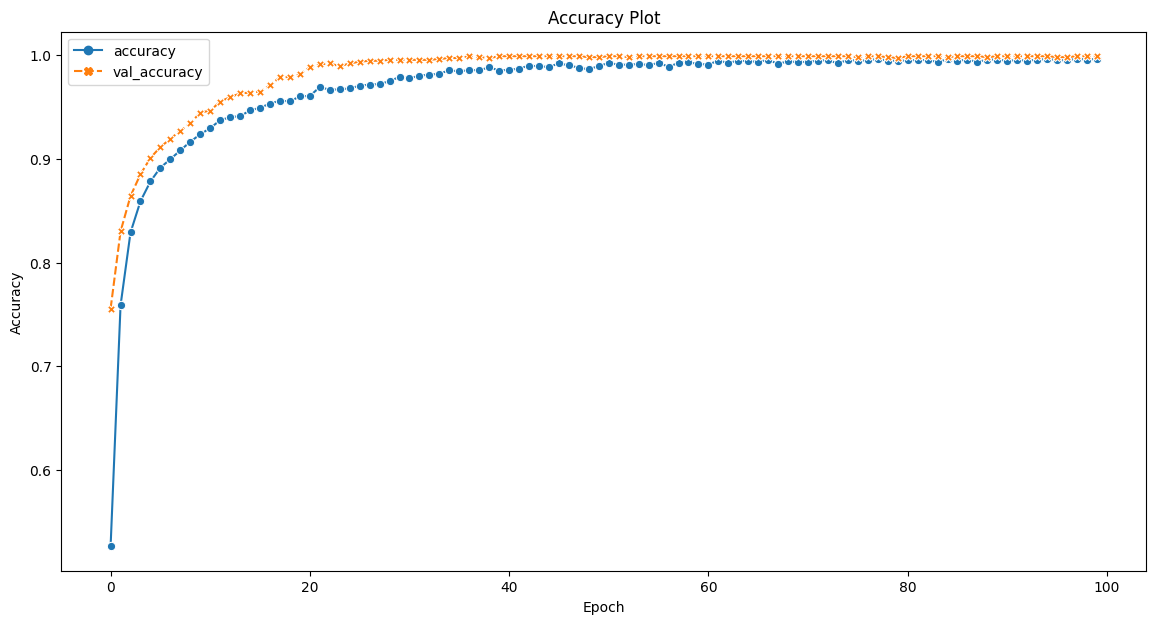

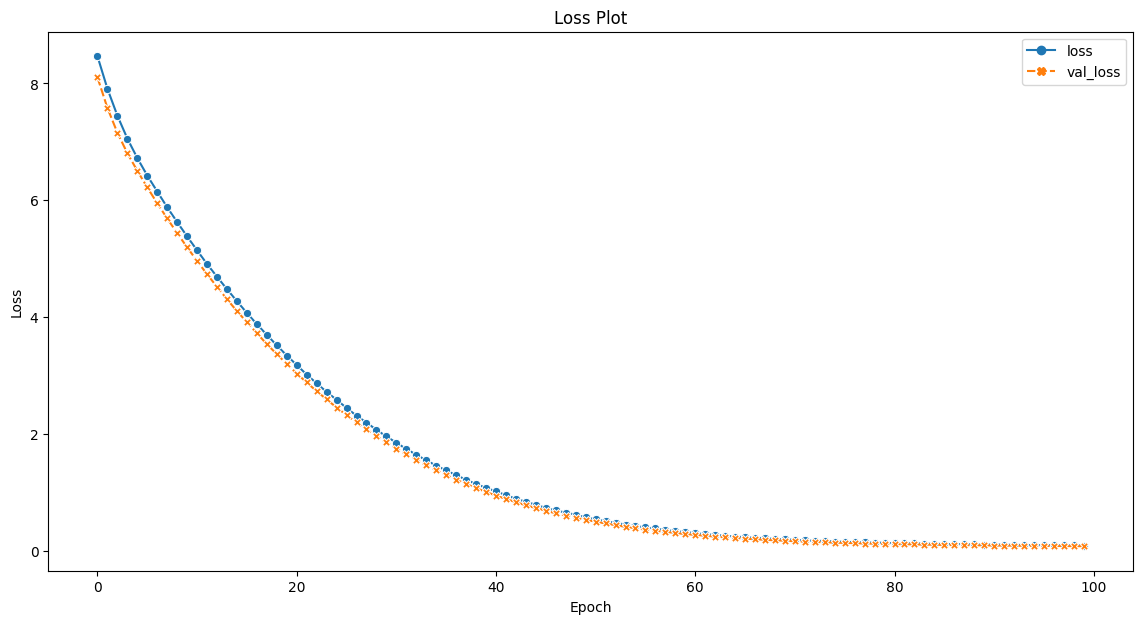

In [14]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize = (14, 7))
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], markers = True)
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("Accuracy Plot.png")
plt.show()

plt.figure(figsize = (14, 7))
sns.lineplot(data=history_df[['loss', 'val_loss']], markers = True)
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("Loss Plot.png")
plt.show()

In [15]:
print("Testing Metrics are as Follows: ")
model.evaluate(test_dataset, return_dict = True)

Testing Metrics are as Follows: 
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9891 - loss: 0.1030


{'accuracy': 0.9885583519935608, 'loss': 0.10783843696117401}

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


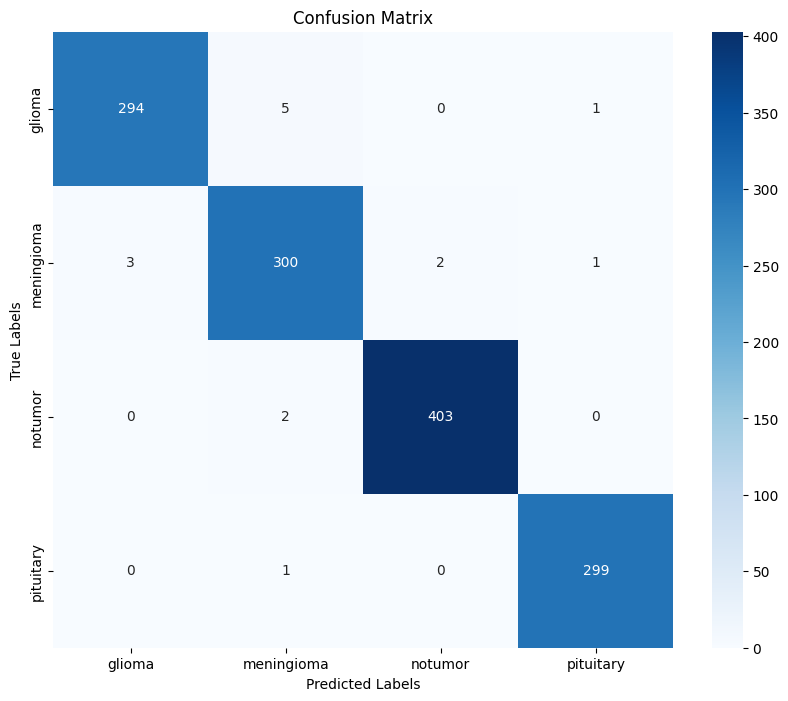

In [16]:
predictions = np.argmax(model.predict(test_dataset), axis = 1)
true_labels = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(true_labels, predictions)
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("Confusion Matrix.png")
plt.show()